In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import yaml
import numpy as np
import random
import torch
import torch.nn as nn
from diffusers import StableDiffusionPipeline
import argparse
from PIL import Image
from datetime import datetime
from torchvision.utils import save_image

from src.visualise import image_grid, latent_to_img, decode_latent, output_to_img
from src.kernel import RBF
from src.embedding import CNN16, CNN64, Average, AverageDim, VAEAverage, Edges, init_weights, Style, VGG, RuleOfThirds, VGGRo3, Latent, VGG_noise
from src.score_utils import get_sigmas, get_score_input
from src.denoise_utils import denoise_particles
from src.steps import Steps

In [2]:
# Using 512x512 resolution
model_id = "stabilityai/stable-diffusion-2-base"
# model_id = "CompVis/stable-diffusion-v1-4"

# tf32 faster computation with Ampere
torch.backends.cuda.matmul.allow_tf32 = True
device = "cuda"
dtype=torch.float32
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=dtype)
# pipe = pipe.to(device)
pipe.safety_checker = None
pipe.enable_attention_slicing() # NOTE: 10% slower inference, but big memory savings
# pipe.enable_sequential_cpu_offload() # NOTE: May slow down inference a lot
pipe.enable_vae_slicing() # TODO: Try to give batches to VAE
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

# Traced UNet? https://huggingface.co/docs/diffusers/optimization/fp16

In [24]:
# Settings
prompts =  ["elephant", "pablo picasso", "left"]
config = {
    "pipe": pipe,
    "height": 512,
    "width": 512,
    "num_inference_steps": 20,
    "num_train_timesteps": 1000,
    "num_init_latents": 1,
    "batch_size": 1,
    "cfg": 8,
    "beta_start": 0.00085,
    "beta_end": 0.012,
    "noise_mask": None,
}

# Seeds
seed=1030
generator = torch.Generator(device).manual_seed(seed)
torch.manual_seed(seed)
np.random.seed(0)
random.seed(0)

# Noise levels
sigmas, timesteps = get_sigmas(config, device=device)
init_latents, text_embeddings = get_score_input(prompts, config, generator=generator, device=device, dtype=dtype)
config = {**config,
          "sigmas": sigmas,
          "timesteps": timesteps,
          "init_latents": init_latents,
          "text_embeddings": text_embeddings
          }

/data/ap2619/particlediffusion/src/score_utils.py:54: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, pipe.unet.in_channels, height//8, width//8),


In [4]:
# Modify init_latents
noise_mask = torch.zeros_like(init_latents)
noise_mask[:,:,:32,:] = 0
config['noise_mask'] = noise_mask

In [27]:
# weights must add up to 1

steps = Steps(init_method="score_multiprompt", weights=[0.5,0.3,0.2])

# Split
# steps = Steps(init_method=None)
# n =3
# steps.add_list(list(range(0,n)),"score_multiprompt",[1]*n, weights=[0,1])
# steps.add_list(list(range(n,20)),"score_multiprompt",[1]*(20-n), weights=[0.5,0.5])

# Could just add noise to noise_mask region at each step i.e. take noise step of mask

# Use steps API to add steps at specific noise levels
# steps.add(0,"langevin_mask",1)
# steps.add_list(list(range(1,5)),"langevin_mask",[1]*5)
# steps.add_all("langevin_mask",5)
# steps.add_list(list(range(10)),method,[2]*10)
# steps.add_list([0,1,2,3],method,[10,10,10,10])
# steps.add_list([5],method,[2])
latent = denoise_particles(
    config, generator, num_particles=1, steps=steps.steps,
    correction_step_type="auto",
    addpart_level=None,
    model=None, 
    repulsive_strength=0, repulsive_strat="kernel"
)
#save
timestamp = datetime.now().strftime('%Y-%m-%d_%H%M%S')
image = output_to_img(decode_latent(latent, config['pipe'].vae))
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
for i, pil_image in enumerate(pil_images):
    pil_image.save(f"data/post_outs/out_{timestamp}_{i}.png")


  0%|          | 0/20 [00:00<?, ?it/s]

56.526512145996094
0
28.643701553344727
1
15.16569709777832
2
8.372246742248535
3
4.808472156524658
4
2.8666281700134277
5
1.7699308395385742
6
1.1290048360824585
7
0.7422522902488708
8
0.5016383528709412
9
0.34759262204170227
10
0.24626339972019196
11
0.1778833568096161
12
0.13063164055347443
13
0.09726026654243469
14
0.07327133417129517
15
0.05590175464749336
16
0.04386698082089424
17
0.04713029786944389
18
0.0008507449529133737
19


In [8]:
for step_method, num_steps, *weights in steps.steps[0]:
    print(weights)

[[]]


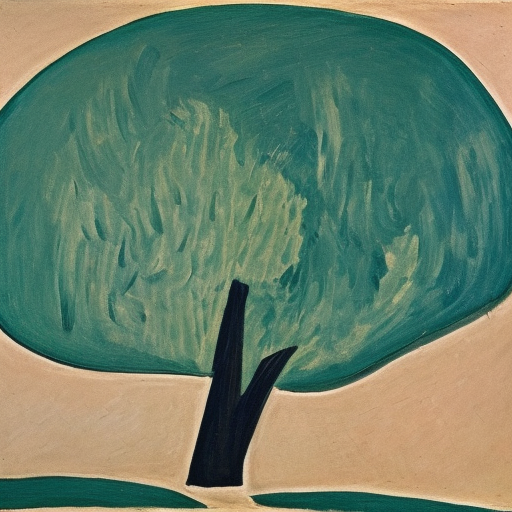

In [26]:
# Plot image results
image = output_to_img(decode_latent(latent, config['pipe'].vae))
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [8]:
init_latents[0,0,...].cpu().numpy().shape

(64, 64)

In [10]:
save_image(init_latents[0,0,...], "noise.png")